In this notebook we make a few small changes for clarity and try and settle the debate on when prediction begins.

In [8]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt


from recurrent_kernel import recurrent_kernel, erf_kernel, diagonal_update_fn, update_fn, weighted_dot
from jax.lax import scan

%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data = jnp.load('u_train.npy')
baseline = jnp.load('K_horizontal_baseline.npy')

In [10]:
scaling = (0.4, 0.9, 0.4)

In [11]:
f = jax.jit(recurrent_kernel, static_argnums=(1, ))
K_recurrent, _ = f(data, erf_kernel, scaling) # compiling

(9999,)


In [7]:
K_recurrent.shape

(10000, 10000)

In [20]:
K_recurrent[:5, :5]

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ],
             [0.        , 0.2893441 , 0.254906  , 0.2459821 , 0.2427905 ],
             [0.        , 0.254906  , 0.37456805, 0.3435434 , 0.33548978],
             [0.        , 0.2459821 , 0.3435434 , 0.39372686, 0.37395144],
             [0.        , 0.2427905 , 0.33548978, 0.37395144, 0.397013  ]],            dtype=float32)

In [21]:
jnp.allclose(K_recurrent[1:, 1:], baseline)

DeviceArray(True, dtype=bool)

In [8]:
%%timeit
f(data, erf_kernel, scaling).block_until_ready()

177 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


is is symmetrical:

In [10]:
jnp.allclose(K_recurrent, K_recurrent.T)

DeviceArray(True, dtype=bool)

How far are we from the diagonal approach?

In [11]:
diagonal = jnp.load('K_diagonal.npy')

In [15]:
jnp.allclose(diagonal[:-1, :-1], K_recurrent[1:, 1:])

DeviceArray(True, dtype=bool)

The same, yeaahhhh.

In [16]:
explicit = jnp.load("K_baseline.npy")

(4000.0, 6000.0)

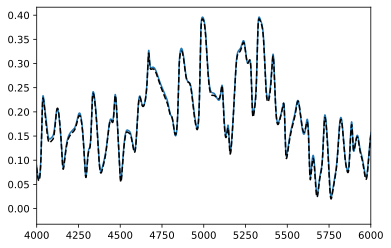

In [28]:
frame = 5000
plt.plot(K_recurrent[1:, 1:][:, frame])
plt.plot(explicit[:, frame], 'k--')

plt.xlim([4000, 6000])

In [25]:
print(jnp.mean(jnp.abs(explicit[:-1, :-1] - K_recurrent[1:, 1:])))
print(jnp.max(jnp.abs(explicit[:-1, :-1] - K_recurrent[1:, 1:])))

0.0038881628
0.017744087


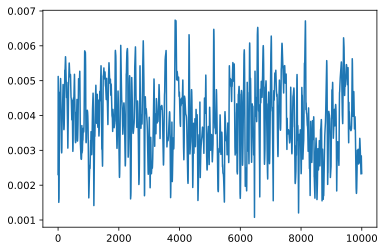

In [27]:
plt.plot(jnp.mean(jnp.abs(explicit[:-1, :-1] - K_recurrent[1:, 1:]), axis=0))

We made the code nicer; now let's get the offset correct. Since we're predicting, we don't need the last data point.

In [4]:
scaling_args = scaling
kernel_fn = erf_kernel

In [5]:
dot_fn = weighted_dot(*scaling_args)
gram = jnp.dot(data[:-1], data[:-1].T)

In [6]:
gram.shape

(9999, 9999)

Now we scan the diagonal and add in zero for the first element:

In [7]:
k_diagonal = scan(
        diagonal_update_fn(kernel_fn, dot_fn),
        0.0,
        jnp.diag(gram),
    )[1]
k_diagonal = jnp.pad(k_diagonal, (1, 0))

In [8]:
k_diagonal.shape

(10000,)

In [9]:
k_diagonal

DeviceArray([0.        , 0.28934404, 0.37456805, ..., 0.41068947,
             0.4108657 , 0.41120026], dtype=float32)

In [10]:
jnp.diag(gram)

DeviceArray([1.4455459, 1.432762 , 1.4154178, ..., 1.6338115, 1.6379329,
             1.6453091], dtype=float32)

In [11]:
uu = dot_fn(jnp.diag(gram), k_diagonal[:-1])

In [12]:
uu.shape

(9999,)

In [13]:
K_recurrent = scan(
        update_fn(kernel_fn, dot_fn, uu),
        jnp.zeros((gram.shape[0],)),
        (gram, uu),
    )[1]

In [14]:
K_recurrent.shape

(9999, 9999)

In [15]:
jnp.diag(K_recurrent)

DeviceArray([0.28934404, 0.37456805, 0.3937268 , ..., 0.41068947,
             0.4108657 , 0.41120026], dtype=float32)

In [16]:
baseline.shape

(9999, 9999)

In [17]:
K_recurrent[:5, :5]

DeviceArray([[0.28934404, 0.254906  , 0.24598213, 0.24279046, 0.24044245],
             [0.254906  , 0.37456805, 0.34354344, 0.33548978, 0.3319669 ],
             [0.24598213, 0.34354344, 0.3937268 , 0.37395144, 0.3682211 ],
             [0.24279046, 0.33548978, 0.37395144, 0.3970129 , 0.38537166],
             [0.24044245, 0.3319669 , 0.3682211 , 0.38537166, 0.3965855 ]],            dtype=float32)

In [18]:
baseline[:5, :5]

array([[0.2893441 , 0.254906  , 0.2459821 , 0.2427905 , 0.24044245],
       [0.254906  , 0.37456805, 0.3435434 , 0.33548978, 0.33196688],
       [0.2459821 , 0.3435434 , 0.39372686, 0.37395144, 0.3682211 ],
       [0.2427905 , 0.33548978, 0.37395144, 0.397013  , 0.38537166],
       [0.24044245, 0.33196688, 0.3682211 , 0.38537166, 0.39658555]],
      dtype=float32)